In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from matplotlib import pyplot as plt
import os
import pandas as pd
from PIL import Image
from sklearn.metrics import confusion_matrix
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

In [2]:
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms

In [3]:
torch.manual_seed(42)
np.random.seed(42)

In [4]:
models = {
    'Shallow MLP': nn.Sequential(
        nn.Linear(128*128, 32),
        nn.ReLU(),
        nn.Linear(32, 3)
    ),
    'Deep MLP': nn.Sequential(
        nn.Linear(128*128, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 3)
    ),
    'Shallow CNN': nn.Sequential(
        nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        nn.Linear(16*64*64, 3) 
    ),
    'Deep CNN': nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        nn.Linear(64*32*32, 128),  
        nn.ReLU(),
        nn.Linear(128, 3)
    )

}

In [5]:
class AIdetec_CNN(Dataset):
    def __init__(self, data_dir="data", img_size=128):
        self.data_dir = data_dir
        self.img_dir = os.path.join(data_dir, "initial_data")
        self.df = pd.read_csv(os.path.join(data_dir, "initial_data.csv"))
        
        self.transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_name = os.path.basename(row["file_name"])  
        label = int(row["label"])

        img_path = os.path.join(self.img_dir, img_name)
        if not os.path.exists(img_path):
            raise FileNotFoundError(f"No se encontró la imagen: {img_path}")

        img = Image.open(img_path).convert("RGB")
        img = self.transform(img)

        return img, label


In [6]:
class AIdetec_MLP(Dataset):
    def __init__(self, data_dir="data", img_size=128):
        self.data_dir = data_dir
        self.img_dir = os.path.join(data_dir, "initial_data")
        self.df = pd.read_csv(os.path.join(data_dir, "initial_data.csv"))
        
        self.transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Grayscale(),
            transforms.Lambda(lambda x: x.view(-1))
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_name = os.path.basename(row["file_name"])  
        label = int(row["label"])

        img_path = os.path.join(self.img_dir, img_name)
        if not os.path.exists(img_path):
            raise FileNotFoundError(f"No se encontró la imagen: {img_path}")

        img = Image.open(img_path).convert("RGB")
        img = self.transform(img)

        return img, label


In [7]:
dataset_CNN = AIdetec_CNN('../data', 128)

train_size_CNN = 800    
val_size_CNN = 200

train_CNN, val_CNN = random_split(dataset_CNN, [train_size_CNN, val_size_CNN])




dataset_MLP = AIdetec_MLP('../data', 128)

train_size_MLP = 800    
val_size_MLP = 200

train_MLP, val_MLP = random_split(dataset_MLP, [train_size_MLP, val_size_MLP])

In [8]:
dl_train_CNN = DataLoader(train_CNN, batch_size=32, shuffle=True)
dl_val_CNN = DataLoader(val_CNN, batch_size=32, shuffle=True)

dl_train_MLP = DataLoader(train_MLP, batch_size=32, shuffle=True)
dl_val_MLP = DataLoader(val_MLP, batch_size=32, shuffle=True)

In [9]:
size = 0
for batch_x, batch_y in dl_train_MLP:
  size += batch_x.shape[0]
  print(batch_x.shape), print(batch_y.shape)
print("Total size: ", size)

torch.Size([32, 16384])
torch.Size([32])
torch.Size([32, 16384])
torch.Size([32])
torch.Size([32, 16384])
torch.Size([32])
torch.Size([32, 16384])
torch.Size([32])
torch.Size([32, 16384])
torch.Size([32])
torch.Size([32, 16384])
torch.Size([32])
torch.Size([32, 16384])
torch.Size([32])
torch.Size([32, 16384])
torch.Size([32])
torch.Size([32, 16384])
torch.Size([32])
torch.Size([32, 16384])
torch.Size([32])
torch.Size([32, 16384])
torch.Size([32])
torch.Size([32, 16384])
torch.Size([32])
torch.Size([32, 16384])
torch.Size([32])
torch.Size([32, 16384])
torch.Size([32])
torch.Size([32, 16384])
torch.Size([32])
torch.Size([32, 16384])
torch.Size([32])
torch.Size([32, 16384])
torch.Size([32])
torch.Size([32, 16384])
torch.Size([32])
torch.Size([32, 16384])
torch.Size([32])
torch.Size([32, 16384])
torch.Size([32])
torch.Size([32, 16384])
torch.Size([32])
torch.Size([32, 16384])
torch.Size([32])
torch.Size([32, 16384])
torch.Size([32])
torch.Size([32, 16384])
torch.Size([32])
torch.Size([32, 

In [10]:
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn

def train_model(model, train_dl, val_dl, epochs=1000, lr=0.1):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []
    cm = None

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0

        for batch_x, batch_y in train_dl:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            optimizer.zero_grad()
            output = model(batch_x)
            loss = criterion(output, batch_y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(output, 1)
            train_correct += (predicted == batch_y).sum().item()

        train_loss_history.append(train_loss / len(train_dl))
        train_acc_history.append(train_correct / len(train_dl.dataset))

        model.eval()
        val_loss = 0.0
        val_correct = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for batch_x, batch_y in val_dl:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                output = model(batch_x)
                loss = criterion(output, batch_y)
                val_loss += loss.item()

                _, predicted = torch.max(output, 1)
                val_correct += (predicted == batch_y).sum().item()

                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(batch_y.cpu().numpy())

        val_loss_history.append(val_loss / len(val_dl))
        val_acc_history.append(val_correct / len(val_dl.dataset))

        cm = confusion_matrix(all_labels, all_preds)

        print(f"Epoch {epoch}, "
              f"Train Loss: {train_loss_history[-1]:.4f}, "
              f"Train Acc: {train_acc_history[-1]:.4f}, "
              f"Val Loss: {val_loss_history[-1]:.4f}, "
              f"Val Acc: {val_acc_history[-1]:.4f}")

    return train_loss_history, train_acc_history, val_loss_history, val_acc_history, cm


In [11]:
train_loss_history_baseMLP, train_acc_history_baseMLP, val_loss_history_baseMLP, val_acc_history_baseMLP, cm_baseMLP = train_model(models['Shallow MLP'], dl_train_MLP, dl_val_MLP, epochs=20, lr=0.0001)

Epoch 0, Train Loss: 0.7704, Train Acc: 0.5000, Val Loss: 0.7440, Val Acc: 0.4700
Epoch 1, Train Loss: 0.7459, Train Acc: 0.5062, Val Loss: 0.7269, Val Acc: 0.5250
Epoch 2, Train Loss: 0.6951, Train Acc: 0.5463, Val Loss: 0.6935, Val Acc: 0.5650
Epoch 3, Train Loss: 0.7057, Train Acc: 0.5200, Val Loss: 0.6952, Val Acc: 0.5550
Epoch 4, Train Loss: 0.6826, Train Acc: 0.5500, Val Loss: 0.7102, Val Acc: 0.5450
Epoch 5, Train Loss: 0.6827, Train Acc: 0.5450, Val Loss: 0.7318, Val Acc: 0.4700
Epoch 6, Train Loss: 0.7048, Train Acc: 0.5075, Val Loss: 0.7162, Val Acc: 0.4750
Epoch 7, Train Loss: 0.6562, Train Acc: 0.6125, Val Loss: 0.7056, Val Acc: 0.5650
Epoch 8, Train Loss: 0.6559, Train Acc: 0.6012, Val Loss: 0.7037, Val Acc: 0.4650
Epoch 9, Train Loss: 0.6652, Train Acc: 0.5650, Val Loss: 0.7072, Val Acc: 0.4700
Epoch 10, Train Loss: 0.6458, Train Acc: 0.6162, Val Loss: 0.6940, Val Acc: 0.5700
Epoch 11, Train Loss: 0.6389, Train Acc: 0.6575, Val Loss: 0.6959, Val Acc: 0.5250
Epoch 12, Trai

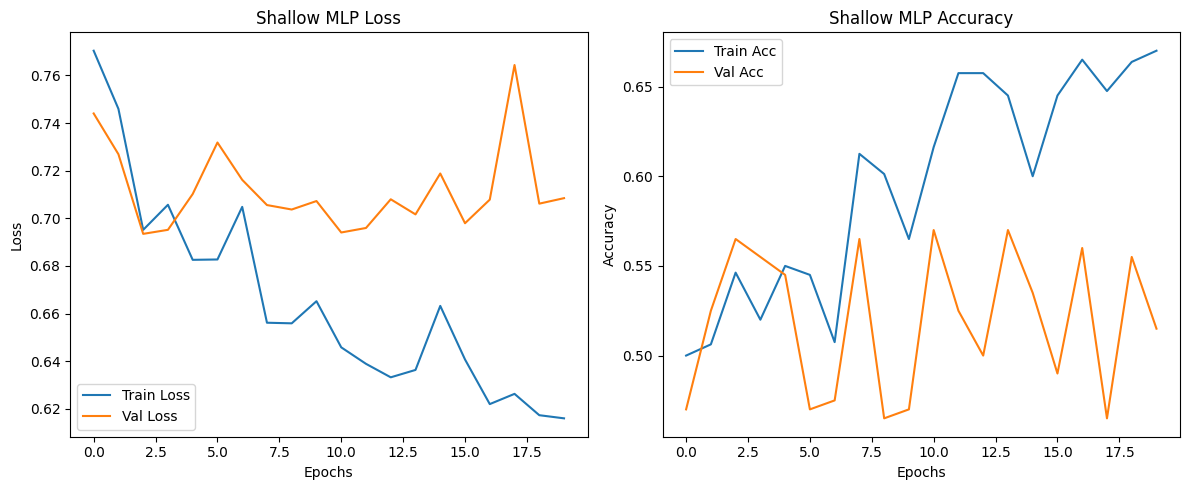

In [12]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history_baseMLP, label='Train Loss')
plt.plot(val_loss_history_baseMLP, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Shallow MLP Loss')
plt.subplot(1, 2, 2)
plt.plot(train_acc_history_baseMLP, label='Train Acc')
plt.plot(val_acc_history_baseMLP, label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Shallow MLP Accuracy')
plt.tight_layout()
plt.savefig("../figures/shallowMLP.png")
plt.show()

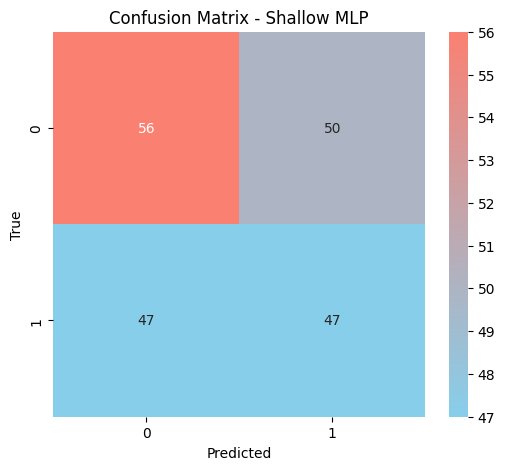

In [39]:
color = ["skyblue", "salmon"]
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", color)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_baseMLP, annot=True, fmt='d', cmap=custom_cmap)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Shallow MLP')
plt.show()

In [14]:
train_loss_history_deepMLP, train_acc_history_deepMLP, val_loss_history_deepMLP, val_acc_history_deepMLP, cm_deepMLP = train_model(models['Deep MLP'], dl_train_MLP, dl_val_MLP, epochs=20, lr=0.0001)

Epoch 0, Train Loss: 0.8169, Train Acc: 0.5000, Val Loss: 0.7756, Val Acc: 0.4700
Epoch 1, Train Loss: 0.7020, Train Acc: 0.5300, Val Loss: 0.6990, Val Acc: 0.5250
Epoch 2, Train Loss: 0.6934, Train Acc: 0.5363, Val Loss: 0.6936, Val Acc: 0.5550
Epoch 3, Train Loss: 0.6939, Train Acc: 0.5262, Val Loss: 0.7102, Val Acc: 0.4750
Epoch 4, Train Loss: 0.6907, Train Acc: 0.5413, Val Loss: 0.6950, Val Acc: 0.5450
Epoch 5, Train Loss: 0.6808, Train Acc: 0.5587, Val Loss: 0.7603, Val Acc: 0.4700
Epoch 6, Train Loss: 0.6833, Train Acc: 0.5663, Val Loss: 0.6928, Val Acc: 0.5850
Epoch 7, Train Loss: 0.6770, Train Acc: 0.5850, Val Loss: 0.7031, Val Acc: 0.5400
Epoch 8, Train Loss: 0.6743, Train Acc: 0.5887, Val Loss: 0.7054, Val Acc: 0.5150
Epoch 9, Train Loss: 0.6729, Train Acc: 0.5600, Val Loss: 0.6791, Val Acc: 0.5400
Epoch 10, Train Loss: 0.6642, Train Acc: 0.6100, Val Loss: 0.6918, Val Acc: 0.5200
Epoch 11, Train Loss: 0.6791, Train Acc: 0.5962, Val Loss: 0.7005, Val Acc: 0.5500
Epoch 12, Trai

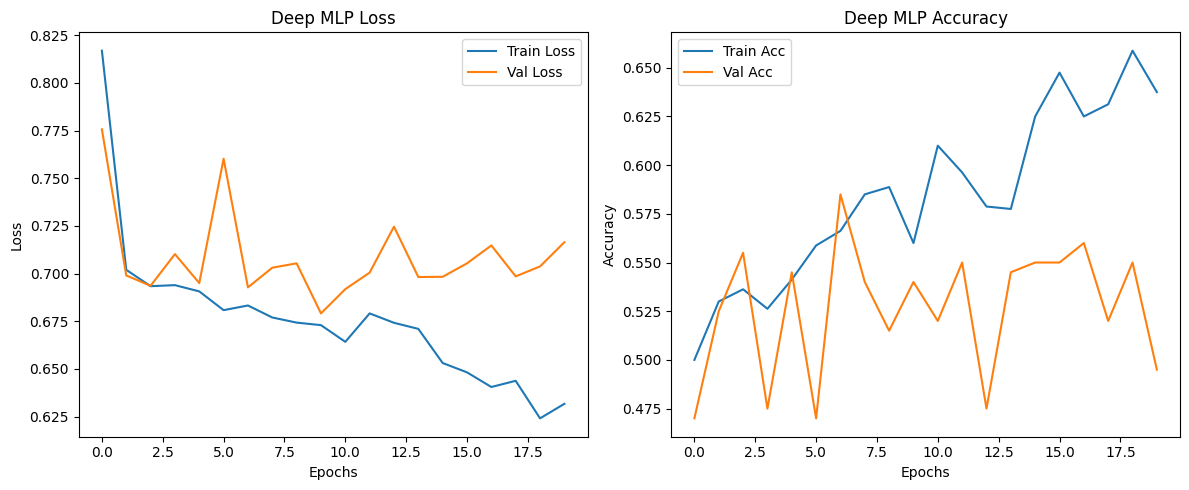

In [15]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history_deepMLP, label='Train Loss')
plt.plot(val_loss_history_deepMLP, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Deep MLP Loss')
plt.subplot(1, 2, 2)
plt.plot(train_acc_history_deepMLP, label='Train Acc')
plt.plot(val_acc_history_deepMLP, label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Deep MLP Accuracy')
plt.tight_layout()
plt.savefig("../figures/deepMLP.png")
plt.show()

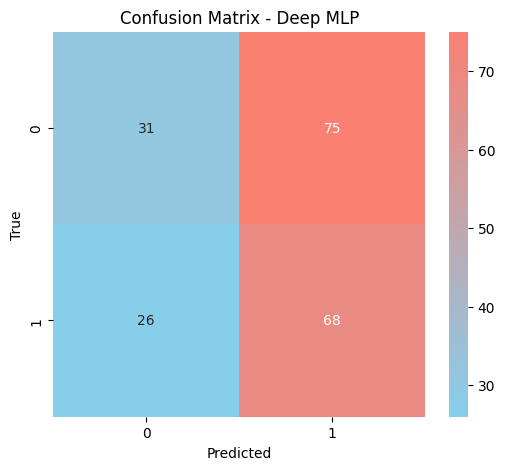

In [37]:
plt.figure(figsize=(6, 5))
sns.heatmap(cm_deepMLP, annot=True, fmt='d', cmap=custom_cmap)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Deep MLP')
plt.show()

In [17]:
train_loss_history_baseCNN, train_acc_history_baseCNN, val_loss_history_baseCNN, val_acc_history_baseCNN, cm_baseCNN = train_model(models['Shallow CNN'], dl_train_CNN, dl_val_CNN, epochs=20, lr=0.0001)

Epoch 0, Train Loss: 0.6907, Train Acc: 0.6088, Val Loss: 0.5973, Val Acc: 0.7750
Epoch 1, Train Loss: 0.5311, Train Acc: 0.7738, Val Loss: 0.5171, Val Acc: 0.8150
Epoch 2, Train Loss: 0.4609, Train Acc: 0.8300, Val Loss: 0.4667, Val Acc: 0.8300
Epoch 3, Train Loss: 0.3993, Train Acc: 0.8562, Val Loss: 0.4455, Val Acc: 0.8450
Epoch 4, Train Loss: 0.3638, Train Acc: 0.8788, Val Loss: 0.4168, Val Acc: 0.8500
Epoch 5, Train Loss: 0.3290, Train Acc: 0.9025, Val Loss: 0.3854, Val Acc: 0.8600
Epoch 6, Train Loss: 0.3122, Train Acc: 0.8962, Val Loss: 0.3875, Val Acc: 0.8650
Epoch 7, Train Loss: 0.2823, Train Acc: 0.9150, Val Loss: 0.3486, Val Acc: 0.8750
Epoch 8, Train Loss: 0.2749, Train Acc: 0.9150, Val Loss: 0.3537, Val Acc: 0.8650
Epoch 9, Train Loss: 0.2513, Train Acc: 0.9375, Val Loss: 0.3440, Val Acc: 0.8850
Epoch 10, Train Loss: 0.2437, Train Acc: 0.9225, Val Loss: 0.3375, Val Acc: 0.8650
Epoch 11, Train Loss: 0.2234, Train Acc: 0.9400, Val Loss: 0.3236, Val Acc: 0.8750
Epoch 12, Trai

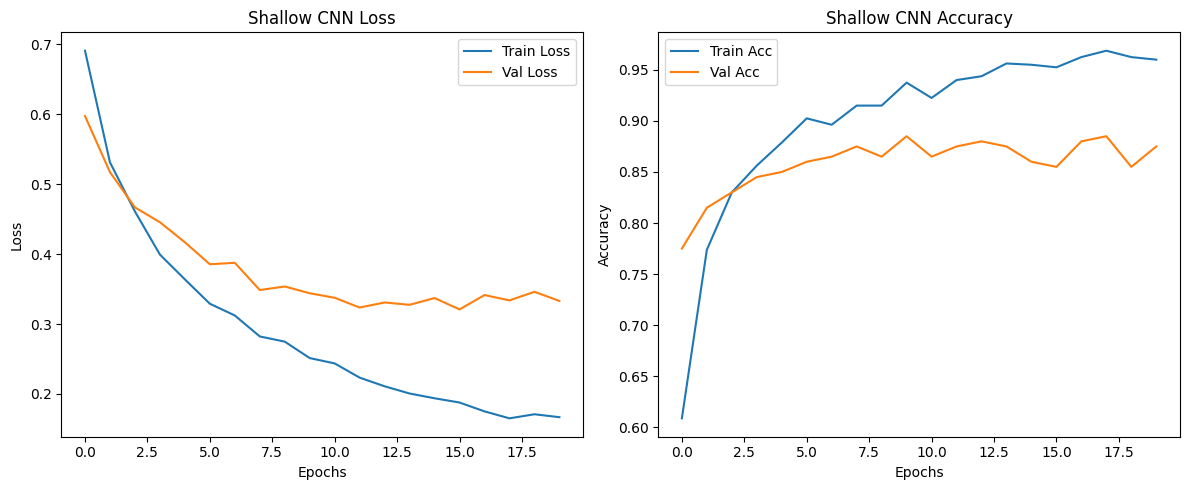

In [18]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history_baseCNN, label='Train Loss')
plt.plot(val_loss_history_baseCNN, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Shallow CNN Loss')
plt.subplot(1, 2, 2)
plt.plot(train_acc_history_baseCNN, label='Train Acc')
plt.plot(val_acc_history_baseCNN, label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Shallow CNN Accuracy')
plt.tight_layout()
plt.savefig("../figures/shallowCNN.png")
plt.show()

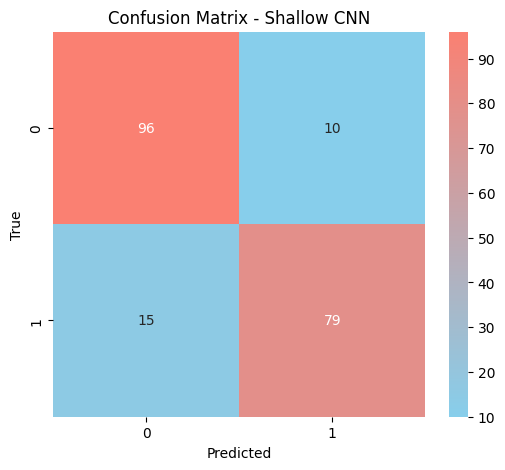

In [38]:
plt.figure(figsize=(6, 5))
sns.heatmap(cm_baseCNN, annot=True, fmt='d', cmap=custom_cmap)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Shallow CNN')
plt.show()

In [20]:
train_loss_history_deepCNN, train_acc_history_deepCNN, val_loss_history_deepCNN, val_acc_history_deepCNN, cm_deepCNN = train_model(models['Deep CNN'], dl_train_CNN, dl_val_CNN, epochs=20, lr=0.0001)

Epoch 0, Train Loss: 0.7111, Train Acc: 0.5550, Val Loss: 0.5836, Val Acc: 0.7450
Epoch 1, Train Loss: 0.5502, Train Acc: 0.7400, Val Loss: 0.4784, Val Acc: 0.8150
Epoch 2, Train Loss: 0.4411, Train Acc: 0.8187, Val Loss: 0.4135, Val Acc: 0.8550
Epoch 3, Train Loss: 0.3700, Train Acc: 0.8538, Val Loss: 0.3802, Val Acc: 0.8300
Epoch 4, Train Loss: 0.3184, Train Acc: 0.8812, Val Loss: 0.3246, Val Acc: 0.8700
Epoch 5, Train Loss: 0.2811, Train Acc: 0.8975, Val Loss: 0.3462, Val Acc: 0.8900
Epoch 6, Train Loss: 0.2741, Train Acc: 0.8900, Val Loss: 0.3481, Val Acc: 0.8200
Epoch 7, Train Loss: 0.2574, Train Acc: 0.8900, Val Loss: 0.3357, Val Acc: 0.8500
Epoch 8, Train Loss: 0.2275, Train Acc: 0.9163, Val Loss: 0.3197, Val Acc: 0.8700
Epoch 9, Train Loss: 0.2224, Train Acc: 0.9137, Val Loss: 0.3404, Val Acc: 0.8850
Epoch 10, Train Loss: 0.2012, Train Acc: 0.9275, Val Loss: 0.3078, Val Acc: 0.8750
Epoch 11, Train Loss: 0.1952, Train Acc: 0.9400, Val Loss: 0.3503, Val Acc: 0.8700
Epoch 12, Trai

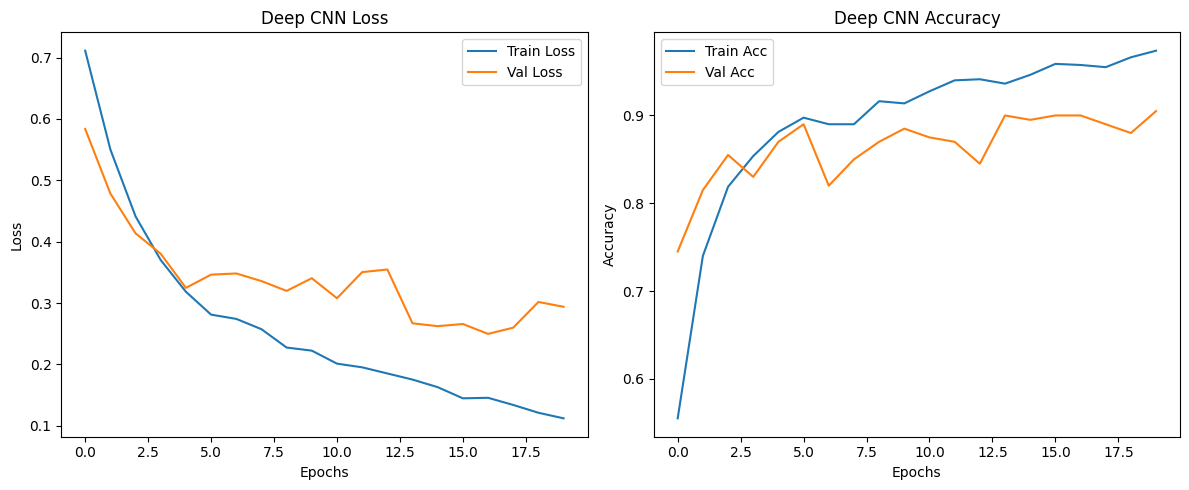

In [21]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history_deepCNN, label='Train Loss')
plt.plot(val_loss_history_deepCNN, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Deep CNN Loss')
plt.subplot(1, 2, 2)
plt.plot(train_acc_history_deepCNN, label='Train Acc')
plt.plot(val_acc_history_deepCNN, label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Deep CNN Accuracy')
plt.tight_layout()
plt.savefig("../figures/deepCNN.png")
plt.show()

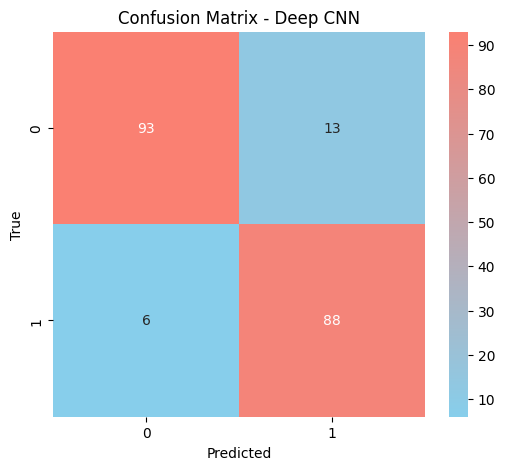

In [ ]:
plt.figure(figsize=(6, 5))
sns.heatmap(cm_deepCNN, annot=True, fmt='d', cmap=custom_cmap)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Deep CNN')
plt.show()

In [23]:
models['Deep CNN Reg'] = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(64*32*32, 128),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(128, 3)
)

In [24]:
train_loss_history_dropout, train_acc_history_dropout, val_loss_history_dropout, val_acc_history_dropout, cm_dropout = train_model(models['Deep CNN Reg'], dl_train_CNN, dl_val_CNN, epochs=20, lr=0.0001)

Epoch 0, Train Loss: 1.0515, Train Acc: 0.6550, Val Loss: 1.5435, Val Acc: 0.5300
Epoch 1, Train Loss: 0.3889, Train Acc: 0.8400, Val Loss: 0.6915, Val Acc: 0.6850
Epoch 2, Train Loss: 0.3151, Train Acc: 0.8725, Val Loss: 0.3054, Val Acc: 0.8500
Epoch 3, Train Loss: 0.2727, Train Acc: 0.8838, Val Loss: 0.3074, Val Acc: 0.8850
Epoch 4, Train Loss: 0.2565, Train Acc: 0.8962, Val Loss: 0.3723, Val Acc: 0.8550
Epoch 5, Train Loss: 0.2215, Train Acc: 0.9113, Val Loss: 0.3574, Val Acc: 0.8450
Epoch 6, Train Loss: 0.1878, Train Acc: 0.9150, Val Loss: 0.2865, Val Acc: 0.8600
Epoch 7, Train Loss: 0.1718, Train Acc: 0.9413, Val Loss: 0.3811, Val Acc: 0.8100
Epoch 8, Train Loss: 0.1436, Train Acc: 0.9475, Val Loss: 0.3309, Val Acc: 0.8700
Epoch 9, Train Loss: 0.1552, Train Acc: 0.9437, Val Loss: 0.4434, Val Acc: 0.7900
Epoch 10, Train Loss: 0.1897, Train Acc: 0.9213, Val Loss: 0.5239, Val Acc: 0.7500
Epoch 11, Train Loss: 0.1402, Train Acc: 0.9550, Val Loss: 0.2764, Val Acc: 0.8850
Epoch 12, Trai

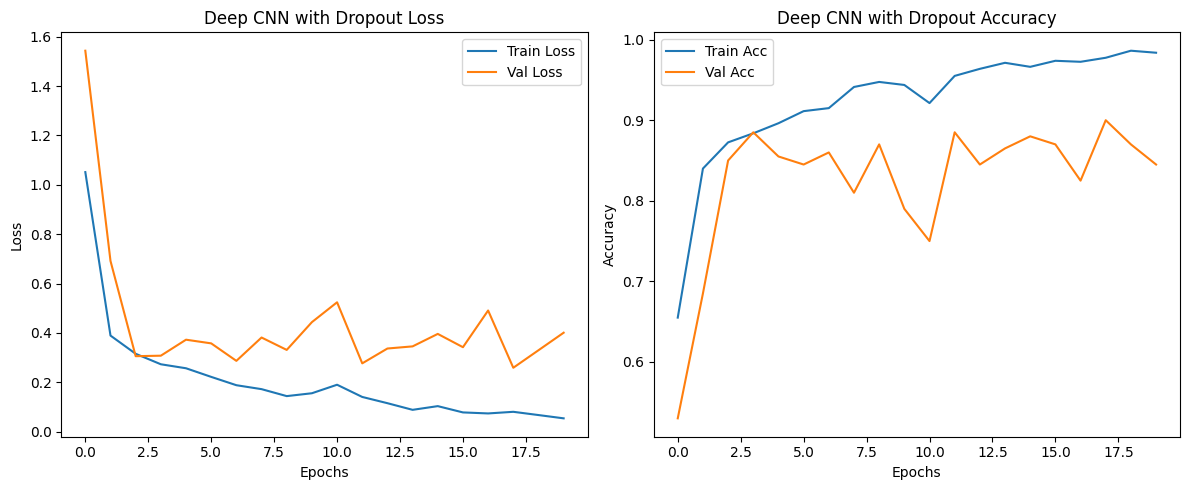

In [25]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history_dropout, label='Train Loss')
plt.plot(val_loss_history_dropout, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Deep CNN with Dropout Loss')
plt.subplot(1, 2, 2)
plt.plot(train_acc_history_dropout, label='Train Acc')
plt.plot(val_acc_history_dropout, label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Deep CNN with Dropout Accuracy')
plt.tight_layout()
plt.savefig("../figures/deepCNN_drop.png")
plt.show()

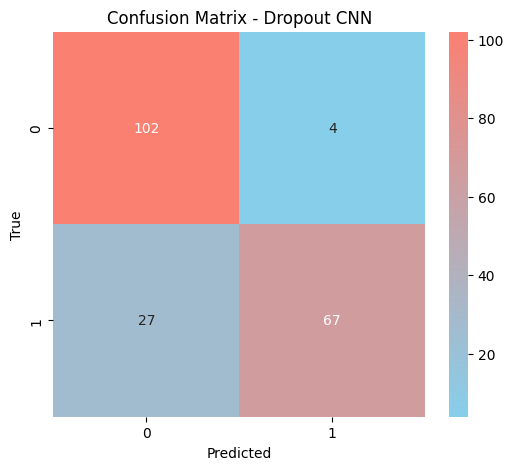

In [41]:
plt.figure(figsize=(6, 5))
sns.heatmap(cm_dropout, annot=True, fmt='d', cmap=custom_cmap)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Dropout CNN')
plt.show()

In [26]:
class AIdetec_CNN_test(Dataset):
    def __init__(self, data_dir="data", img_size=128):
        self.data_dir = data_dir
        self.img_dir = os.path.join(data_dir, "test")
        self.df = pd.read_csv(os.path.join(data_dir, "test.csv"))
        
        self.transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_name = os.path.basename(row["file_name"])  
        label = int(row["label"])

        img_path = os.path.join(self.img_dir, img_name)
        if not os.path.exists(img_path):
            raise FileNotFoundError(f"No se encontró la imagen: {img_path}")

        img = Image.open(img_path).convert("RGB")
        img = self.transform(img)

        return img, label



In [27]:
dataset_CNN_test = AIdetec_CNN_test('../data', 128)
dl_test_CNN = DataLoader(dataset_CNN_test, batch_size=32, shuffle=True)

FileNotFoundError: [Errno 2] No such file or directory: '../data\\test.csv'

In [ ]:
size = 0
for batch_x, batch_y in dl_test_CNN:
  size += batch_x.shape[0]
  print(batch_x.shape), print(batch_y.shape)
print("Total size: ", size)

torch.Size([32, 3, 128, 128])
torch.Size([32])
torch.Size([32, 3, 128, 128])
torch.Size([32])
torch.Size([32, 3, 128, 128])
torch.Size([32])
torch.Size([32, 3, 128, 128])
torch.Size([32])
torch.Size([32, 3, 128, 128])
torch.Size([32])
torch.Size([32, 3, 128, 128])
torch.Size([32])
torch.Size([8, 3, 128, 128])
torch.Size([8])
Total size:  200


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

model = models['Deep CNN']
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in dl_test_CNN:
        imgs, labels = imgs.to(device), labels.to(device)

        outputs = model(imgs)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

acc = accuracy_score(all_labels, all_preds)
print(f"Accuracy en test: {acc:.4f}")

cm_test = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_test, annot=True, fmt='d', cmap=custom_cmap)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Deep CNN (Test)')
plt.show()

Accuracy en test: 0.8450
